<a href="https://colab.research.google.com/github/elinneaeriksson/TransportAI1/blob/main/Handin1_Linnea_Eriksson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Data exploration & preparation



In [2]:


url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df_full = pd.read_csv(url)

df_full.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


In [3]:

# Remove excess columns
df_full = df_full.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)

# derive zscore
from scipy.stats import zscore
import numpy as np

df_full.apply(zscore)

# remove outlier values.
threshold = 3;
df = df_full[np.abs(zscore(df_full['Arrival_delay'])) < threshold]

print("Number of data points", df.shape[0])

outliers = df_full[np.abs(zscore(df_full['Arrival_delay'])) >= threshold]
print("Number of outliers: ", outliers.shape[0])

Number of data points 2137
Number of outliers:  42


<Axes: xlabel='Arrival_delay', ylabel='Count'>

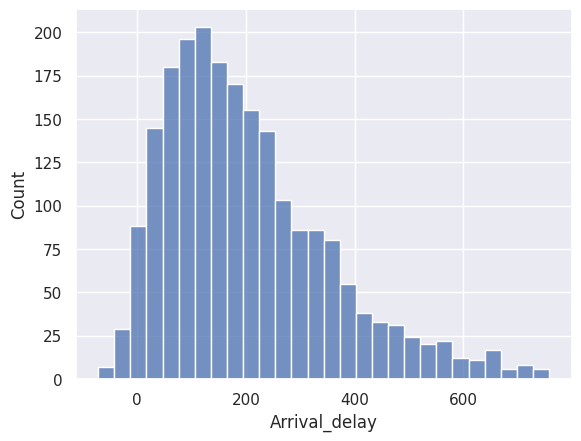

In [4]:
# Histogram of delays
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.histplot(x=df['Arrival_delay'])

In [5]:
# Correlation between variables
corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

,Arrival_delay
Arrival_delay,1.000000
Upstream_stop_delay,0.991597
Dwell_time,0.250254
Recurrent_delay,0.173748
Scheduled_travel_time,0.094035


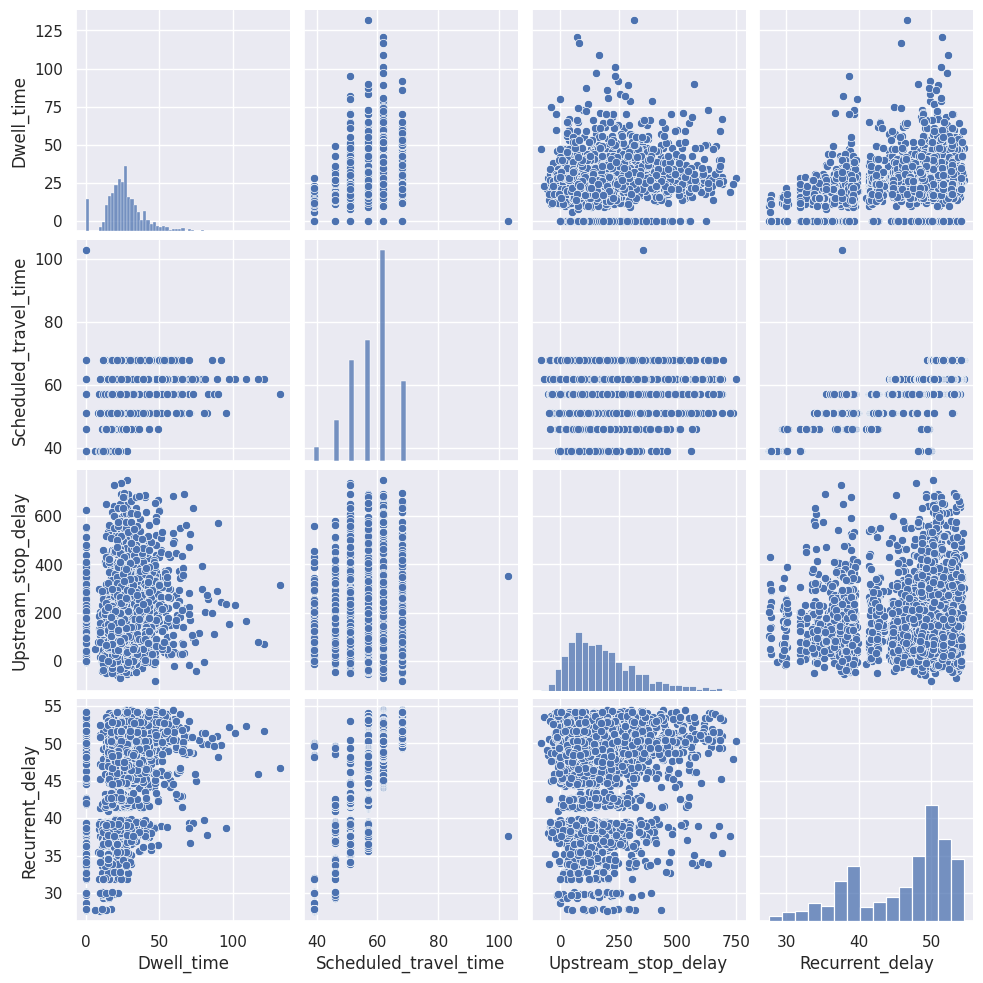

In [6]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

sns.pairplot(x)

# Train and test split

In [7]:
# 20 % used for training
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Hyperparameter tuning

In [8]:
import xgboost as xgb

# Using grid search for hyperparameter tuning
model = xgb.XGBRegressor()

#default values: subsample=1, learning rate =0.1, n_estimators = 100, max_depth=3
grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth' : [2, 3, 4],
    'subsample': [0.5, 0.7, 1],
    'n_estimators':[100,500,1000]
}

grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=5, verbose=1)

grid_search.fit(X_train, y_train)

best_score = grid_search.best_score_
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print score and best parameters.
print('Best parameter:',best_params)
print('Best score:',best_score)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameter: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Best score: 0.9913085896950682


# Model training


In [9]:
model.fit(X_train, y_train)

#use the best model
y_pred = best_model.predict(X_test)

# Model evaluation

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 10.0888780962641
Mean Squared Error: 243.58948615022695
R-squared: 0.9891170419350999


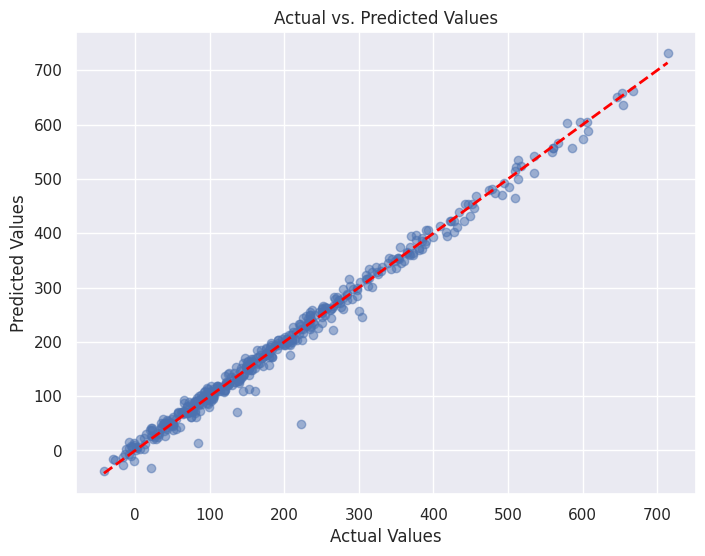

In [11]:
import matplotlib.pyplot as plt

# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
#diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

plt.show()

# Comment:

### Model structure

The model implements xGBoost to predict the delay time at the bus stop. The model input features are the upstream stop delay, the dwell time, recurrent delay and the scheduled travel time.
43 outlier values were removed, leaving 2137 to be used in the model: 80 % for training and 20% for testing.

### xGBoost parameters and performance

Hyperparameter tuning was performed through a grid search, in which

Testing performance:
Mean Absolute Error: 10.709869229638432
Mean Squared Error: 210.20674742957073
R-squared: 0.9929508035333047

The following values indicates a good performance of the model for this data.

### Reflection/Discussion

A high correlation between the input features and the output feature is desired. This means that for example the scheduled travel time might not be meaningful to use in the model, since it is explaining such a small part of the variance in delay. Other predicting variables that could be derived from the dataset is weekday or time of the day. These could also be interesting to explore and perhaps use in the model. xGBoost is generally robust to outliers (source), so removing outlier values might not be neccessary. More parameter values could have been tested to further improve the model.

Other transportation problems where regression models could be applied are for example predicting the number of passengers or vehicles during a given time, the number of accidents or to estimate travel times.

## References
-